<img src="../docs/qpcr_small.svg" width="42"> 
<font size="+10">qpcr - Getting Started</font>
<br>

---

In this Notebook you will get some basic introduction to using the `qpcr` module. Including an overview of the main and submodules, input data and resulting outputs.

### Installing `qpcr`
---
`qpcr` can be directly installed via `pip` using

```python
pip install qpcr
```

### Basic structure of `qpcr`
----------------------------------------------------------------

The `qpcr` module consists of the "main" module that essentially defines everything you need
to work with your data and compute `Delta-Delta-Ct` values for your assays. However, it does not do so on its own but relies on a number of submodules to achieve this. For some features you will also directly have to work with these submodules. 

#### Submodules

| Module | Description |
|---|---|
| `qpcr`          | The main `qpcr` module that defines the essentials for performing Delta-Delta-Ct analysis. |
| `qpcr.Readers` | Defines the classes that will help read your input data files. |
| `qpcr.Plotters` | Defines classes that will allow you to quickly and easily visualise your results. |
| `qpcr.Filters` | Defines classes that allow you to filter out bad Ct values from your assays. |
| `qpcr.Parsers` | Defines classes that allow you to extract data from "irregular" datafiles (`Parsers` are already implemented in many `Readers`). |
| `qpcr.Pipes` | Contains pre-implemented pipelines that assemble fully-working `Delta-Delta-Ct` analyses and only require minimal user setup. |



### Terminology
----------------------------------------------------------------

`qpcr` has a number of important terms that are not part of standard nomenclature of "qPCR experiments". In order to efficiently use `qpcr` you should get familiar with these terms (don't worry they are neither super complex nor very many). Please, check out the [API documentation](https://noahhenrikkleinschmidt.github.io/qpcr/index.html) to learn more about terminology before reading on. 

### Input Data
---

`qpcr` is able to read input datafiles in both `csv` and `excel` format. 
As described in the [API documentation](https://noahhenrikkleinschmidt.github.io/qpcr/index.html),
there are multiple types of input datafiles that `qpcr` can work with. 

#### "Regular" single-assay files
Contain only a replicate identifier and Ct column from a single assay.


|id|Ct|
|---|---|
| ctrl1| 5.67 |
| ctrl2| 5.79 |
| ctrl3 | 5.86 |
| condA1 | 5.34 |
| ... | ... |

<br>

> Note
>
> The actual names of the columns are irrelevant, but their order is essential!


#### "Irregular" files
"Irregular" files may either contain one single dataset or multiple datasets. Note, we will use the term "assay" henceforth to talk more intuitively about the more formally correct "dataset".
Files that specify multiple assays are called "multi-assay files". They specify _each assay_ in a _separate table_  (separated either by at least one blank row or column between them). However, the architecture of the indivdual tables is still that of the "regular".

|                     |                    |            |      |      |
| ------------------- | ------------------ | ---------- | ---- | ---- |
| Some meta-data here | maybe today's date |            |      |      |
|                     |                    |            |      |      |
| Assay 1             |                    |            |      |      |
| id                  | Ct                 | other_data |      |      |
| ctrl1               | 5.67               | ...        |      |      |
| ctrl2               | 5.79               | ...        |      |      |
| ...                 | ...                |            |      |      |
|                     |                    |            |   <- blank line here!   |      |
| Assay 2             |                    |            |      |      |
| id                  | Ct                 | other_data |      |      |
| ctrl1               | 10.23              | ...        |      |      |
| ctrl2               | 10.54              | ...        |      |      |
| ...                 | ...                |            |      |      |

<br></br>

> Note
>
> This setup also works transposedly (i.e. assays are next to each other instead of above one another, but it does require that the assay identifiers are either in the same row or colum!)
> 
> Also, the column names are important for file reading and must be specified.


#### "Big Table" Files
"Big Table" files contain are multi-assay files that specify all their assay in one single "big table". There are two kinds of "Big Table" files called `vertical` or `horizontal`. Big Table files are considered "irregular" so they allow additional meta-data etc. alongside the actual "big table".

#### `Vertical` Big Table Files
Contain a replicate identifier, a Ct value, and an assay identifier column. Replicate groups are thus "vertically" arranged. 

|assay|id|Ct| other_data |
|---|---|---|---|
| assay 1| ctrl1| 5.67 | ... |
| assay 1| ctrl2| 5.79 | ... |
| ...| ... | ... | ... |
| assay 2| ctrl1 | 10.23 | ... |
| ...| ... | ... | ... |

<br></br>

> Note
>
> This requires column names for file reading!



#### `Horizontal` Big Table Files
Contain replicate identifier and assay identifier columns but specify the actual Ct values in side-by-side neighbouring columns. Thus replicate groups are arranged "horizontally". 


| assay   | ctrl1 | ctrl2 | ...  | other_data |
| ------- | ----- | ----- | ---- | ---------- |
| assay 1 | 5.67  | 5.79  | ...  | ...        |
| assay 2 | 10.23 | 10.54 | ...  | ...        |
| ...     | ...   | ...   | ...  | ...        |

<br></br>

> Note
>
> This requires column names, manually specified `replicates`, and `decorators` for file reading!
> You can [learn more about replicates](https://noahhenrikkleinschmidt.github.io/qpcr/index.html#replicates) and [learn more about decorators](https://noahhenrikkleinschmidt.github.io/qpcr/Parsers.html#decorators) in the API documentation. 


### Reading your data

`qpcr` reads your datafiles using the `Readers` from the `qpcr.Readers` submodule. However, as a central hub the main `qpcr` module provides the `DataReader` class that will automatically try to determine the appropriate Reader for your datafile, given the setup you provide. 

> Note
>
> The `DataReader` is designed for easy reading cases and should be appropriate for most cases 
> most of the time. However, if you find that your datafile is not properly working with the `DataReader`, then use one of the `qpcr.Readers` or even one of the `qpcr.Parsers` directly to manually read in your data. 

### First look at some code examples
----

There are a number of more detailed tutorials available, so please check these out to learn more about using `qpcr`. Here, we will just give a very prief preview of doing some Delta-Delta-Ct analysis so you get a feeling of the "flavour" of `qpcr`.

In the code below we will just use the main `qpcr` module to manually assemble our workflow. Much of this code can be omitted when using a pre-defined pipeline from the `qpcr.Pipes` submodule.

In [1]:
# import the module
import qpcr
from qpcr.Plotters import PreviewResults

In [2]:
# declare some datafiles
assays = [ "./Example Data/HNRNPL_prot.csv", "./Example Data/HNRNPL_nmd.csv" ]
normalisers = [ "./Example Data/28S.csv", "./Example Data/actin.csv" ]

# read the data files
reader = qpcr.DataReader()

assays = [ reader.read(file) for file in assays ]
normalisers = [ reader.read(file) for file in normalisers ]


In [3]:
# now set up a manual Delta-Delta-Ct workflow

# first Delta-Ct computed by the qpcr.Analyser
analyser = qpcr.Analyser()

# compute Delta-Ct
assays = [ analyser.pipe(assay) for assay in assays ]
normalisers = [ analyser.pipe(normaliser) for normaliser in normalisers ]

# second Delta-step (to get Delta-Delta-Ct) computed by qpcr.Normaliser
normaliser = qpcr.Normaliser()

# compute Delta-Delta-Ct
normaliser.link( assays = assays, normalisers = normalisers )
normaliser.normalise()


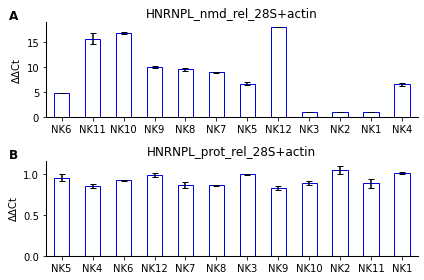

In [4]:
# get and inspect results

results = normaliser.get()

preview = PreviewResults(mode = "static")
preview.link(results)

fig = preview.plot()

In [7]:
# also show summary statistics view of the results
results.stats()

group                      assay       mean     stdev     median  \
11      5   HNRNPL_nmd_rel_28S+actin   4.842562  0.060002   4.842562   
21     10   HNRNPL_nmd_rel_28S+actin  15.772739  1.024227  15.772739   
19      9   HNRNPL_nmd_rel_28S+actin  16.941957  0.190889  16.941957   
17      8   HNRNPL_nmd_rel_28S+actin  10.105629  0.226306  10.105629   
15      7   HNRNPL_nmd_rel_28S+actin   9.623898  0.273373   9.623898   
13      6   HNRNPL_nmd_rel_28S+actin   8.969974  0.124859   8.969974   
9       4   HNRNPL_nmd_rel_28S+actin   6.717150  0.295022   6.717150   
23     11   HNRNPL_nmd_rel_28S+actin  18.106299  0.005835  18.106299   
5       2   HNRNPL_nmd_rel_28S+actin   1.037911  0.005383   1.037911   
3       1   HNRNPL_nmd_rel_28S+actin   1.072644  0.015405   1.072644   
1       0   HNRNPL_nmd_rel_28S+actin   1.039614  0.039614   1.039614   
7       3   HNRNPL_nmd_rel_28S+actin   6.598869  0.288495   6.598869   
8       4  HNRNPL_prot_rel_28S+actin   0.957835  0.042069   0.957835   
6       3  HNRNPL_prot_rel_28S+actin   0.856391  0.022619   0.856391   
10      5  HNRNPL_prot_rel_28S+actin   0.927049  0.008274   0.927049   
22     11  HNRNPL_prot_rel_28S+actin   0.988872  0.024304   0.988872   
12      6  HNRNPL_prot_rel_28S+actin   0.868270  0.036139   0.868270   
14      7  HNRNPL_prot_rel_28S+actin   0.865168  0.003593   0.865168   
4       2  HNRNPL_prot_rel_28S+actin   1.002580  0.008699   1.002580   
16      8  HNRNPL_prot_rel_28S+actin   0.836537  0.027424   0.836537   
18      9  HNRNPL_prot_rel_28S+actin   0.896784  0.020972   0.896784   
2       1  HNRNPL_prot_rel_28S+actin   1.055505  0.054296   1.055505   
20     10  HNRNPL_prot_rel_28S+actin   0.891338  0.054804   0.891338   
0       0  HNRNPL_prot_rel_28S+actin   1.017632  0.017632   1.017632   

   group_name  
11        NK6  
21       NK11  
19       NK10  
17        NK9  
15        NK8  
13        NK7  
9         NK5  
23       NK12  
5         NK3  
3         NK2  
1         NK1  
7         NK4  
8         NK5  
6         NK4  
10        NK6  
22       NK12  
12        NK7  
14        NK8  
4         NK3  
16        NK9  
18       NK10  
2         NK2  
20       NK11  
0         NK1